# Gaussian Mixture Models Implementation

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Organized_Chaos-orange)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/tree/40957563757f7dce3fb02821b42a181426857780/omnivault/machine_learning/mixture/gmm.py)

```{contents}
:local:
```

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import matplotlib.pyplot as plt


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
    from omnivault.machine_learning.estimator import BaseEstimator
    from omnivault.utils.reproducibility.seed import seed_all
else:
    raise ImportError("Root directory not found.")

import random
from functools import partial
from typing import Any, Dict, Tuple, TypeVar, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.collections import PathCollection
from rich.pretty import pprint
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, load_iris, make_blobs
from sklearn.model_selection import train_test_split

use_svg_display()

Training:   5%|▌         | 25/500 [00:03<00:59,  8.02iter/s]


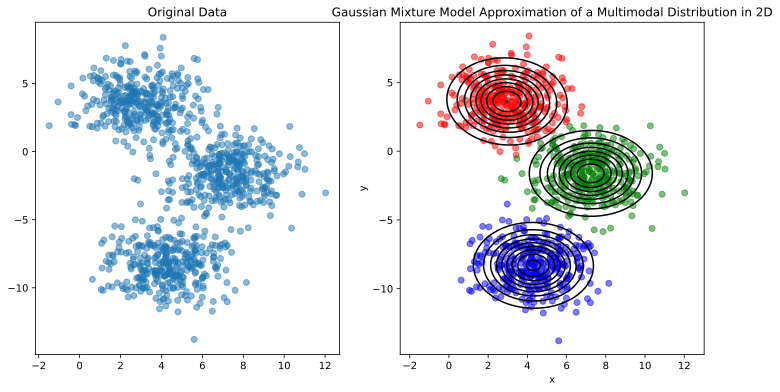

In [2]:
from __future__ import annotations

import logging
from typing import Any, Literal, Tuple, cast

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from scipy.stats import multivariate_normal
from tqdm import tqdm

from omnivault.machine_learning.clustering.kmeans import KMeansLloyd
from omnivault.machine_learning.estimator import BaseEstimator
from omnivault.utils.reproducibility.seed import seed_all

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


class GaussianMixtureModel(BaseEstimator):
    """
    Initialize a Gaussian Mixture Model (GMM) with the specified hyperparameters.

    Parameters
    ----------
    num_components : int, default=3
        The number of Gaussian components in the mixture model.

    init : str, default="random"
        The method used for initialization of the GMM parameters.
        Currently, only "random" and "kmeans" is supported.
        If "random" is chosen, it initializes the means randomly
        from the data.

    max_iter : int, default=100
        The maximum number of iterations for the EM algorithm.

    tol : float, default=1e-8
        The convergence threshold for the EM algorithm. The algorithm will stop when
        the improvement in the log-likelihood is smaller than this value.

    random_state : int, default=42
        The random seed for reproducible results. Pass an int for reproducible
        results across multiple function calls.
    """

    def __init__(
        self,
        num_components: int = 3,
        *,  # all following args are keyword-only
        init: str = "random",
        max_iter: int = 100,
        tol: float = 1e-8,
        random_state: int = 42,
    ) -> None:
        super().__init__()
        self.num_components = num_components  # K
        self.init = init  # random init
        self.max_iter = max_iter
        self.tol = tol

        self.random_state = random_state
        seed_all(self.random_state, seed_torch=False, set_torch_deterministic=False)

        # initialized during construction
        self.prev_marginals_: float | np.floating[Any] = -np.inf
        self.converged_: bool = False
        self.iter_: int = 0

        # not initialized during construction
        self.weights_: NDArray[np.floating[Any]]  # (K,)
        self.means_: NDArray[np.floating[Any]]  # (K, D)
        self.covariances_: NDArray[np.floating[Any]]  # (K, D, D)
        self.responsibilities_: NDArray[np.floating[Any]]  # (N, K)

    def _initialize(self, X: NDArray[np.floating[Any]]) -> None:
        """
        Initialize the parameters of the Gaussian Mixture Model.

        This method initializes the mixing weights, means, and covariances of the GMM components.
        The parameters can be initialized either randomly or using the K-means clustering algorithm.

        Parameters
        ----------
        X : NDArray[np.floating[Any]]
            The input data, a 2D array of shape (num_samples, num_features).

        Raises
        ------
        ValueError
            If the `init` attribute is not "random" or "kmeans".
        """
        if self.init == "random":
            # fmt: off
            # equivalent to [1, 1, ..., 1] / K
            self.weights_ = np.full(self.num_components, 1 / self.num_components)         # (K,)
            self.means_ = X[np.random.choice(self.num_samples, self.num_components)]      # (K, D)  # noqa: NPY002
            self.covariances_ = np.array(                                                 # (K, D, D)
                [np.cov(X.T) for _ in range(self.num_components)]
            )
            # fmt: on
        elif self.init == "kmeans":
            kmeans = KMeansLloyd(self.num_components, random_state=self.random_state)
            kmeans.fit(X)

            labels = kmeans.labels
            # take kmeans labels and use them to initialize the GMM
            self.weights_ = np.bincount(labels) / self.num_samples
            # means is the centroids of the kmeans
            self.means_ = kmeans.centroids
            # covariances is the covariance of each cluster k
            self.covariances_ = np.array([np.cov(X[labels == k].T) for k in range(self.num_components)])
        else:
            raise ValueError(f"Invalid init method '{self.init}'")

    def _get_prior(self) -> NDArray[np.floating[Any]]:
        """Compute the prior probabilities of each cluster k = 1, ..., K.

        Returns:
            ndarray: A 1D array of shape (K,) containing the prior probabilities
                of each Gaussian component.
        """
        return self.weights_  # (K,)

    def _get_likelihood(
        self,
        X: NDArray[np.floating[Any]],
        means: NDArray[np.floating[Any]],
        covariances: NDArray[np.floating[Any]],
    ) -> NDArray[np.floating[Any]]:
        """Compute the likelihood of each sample x^{(n)} given the current
        model parameters, mu, and sigma.

        Parameters
        ----------
        X : array-like of shape (N, D)
            A 2D array containing the input data,
            where N is the number of samples and D is the dimensionality
            of the data.

        means : array-like of shape (K, D)
            A 2D array containing the means of each Gaussian component, where
            K is the number of components and D is the dimensionality of the data.

        covariances : array-like of shape (K, D, D)
            A 3D array containing the covariance matrices of each Gaussian component.

        Returns
        -------
        likelihoods: ndarray : array-like of shape (N, K)
            A 2D array containing the likelihood of
            each sample x^{(n)} for each Gaussian component k = 1, ..., K.
        """
        # fmt: off
        likelihoods = np.zeros((self.num_samples, self.num_components))                   # (N, K)

        # TODO: faster version but less readable
        # for k in range(self.num_components):
        #     mu_k = self.means[k]                                                        # (D,)
        #     sigma_k = covariances[k]                                                    # (D, D)
        #     likelihoods[:, k] = multivariate_normal.pdf(X, mu_k, sigma_k)               # (N,)

        for n in range(self.num_samples):
            xn = X[n]                                                                     # (D,)
            for k in range(self.num_components):
                mu_nk = means[k]                                                          # (D,)
                sigma_nk = covariances[k]                                                 # (D, D)
                likelihoods[n, k] = multivariate_normal.pdf(xn, mu_nk, sigma_nk)          # (1,)
        # fmt: on
        return likelihoods  # (N, K)

    def _get_marginal(
        self, likelihoods: NDArray[np.floating[Any]], prior: NDArray[np.floating[Any]]
    ) -> NDArray[np.floating[Any]]:
        """Compute the marginal likelihood of the data X.

        This is equivalent to finding the marginal likelihood of each
        sample x^{(n)} for all samples n = 1, ..., N.

        Parameters
        ----------
        likelihoods : array-like of shape (num_samples, num_components)
            The likelihood of each sample x^{(n)} for each Gaussian
            component k = 1, ..., K.

        prior : array-like of shape (num_components,)
            The prior probabilities of each Gaussian component.

        Returns
        -------
        marginals: array-like of shape (num_samples, 1)
            A 2D array containing the marginal likelihood of
            each sample x^{(n)} for all samples n = 1, ..., N.
        """
        marginals = np.zeros((self.num_samples, 1))  # (N, 1)

        for n in range(self.num_samples):
            marginals[n] = np.sum(likelihoods[n] * prior)
        return marginals  # (N, 1)

    def broadcast_prior(self, prior: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Broadcast prior from shape of (K,) to (N, K) where
        each row is the prior distribution of shape (K,)."""
        prior_vector = prior[np.newaxis, :]  # (1, K)
        prior_matrix = np.repeat(prior_vector, self.num_samples, axis=0)  # (N, K)
        return prior_matrix  # (N, K)

    def get_weighted_likelihood(
        self, prior: NDArray[np.floating[Any]], likelihoods: NDArray[np.floating[Any]]
    ) -> NDArray[np.floating[Any]]:
        """
        Compute the weighted likelihood (joint probability) of observing the
        latent variable z and data point x.

        Parameters
        ----------
        prior : array-like of shape (num_components,)
            The prior probabilities of each Gaussian component.

        likelihoods : array-like of shape (num_samples, num_components)
            The likelihood of each data point in X belonging to each Gaussian component.

        Returns
        -------
        weighted_likelihood : array-like of shape (num_samples, num_components)
            The joint probability of observing both the data point x and the Gaussian
            component z for each data point and Gaussian component combination.
        """
        # repeat prior for each sample
        prior_matrix = self.broadcast_prior(prior)  # (N, K)
        # for readability, I broadcast the prior to the shape of the likelihoods
        # instead of relying on numpy's automatic broadcasting.
        np.testing.assert_allclose(prior_matrix * likelihoods, prior * likelihoods)
        return prior_matrix * likelihoods  # (N, K)

    # this is the posterior
    def _estimate_responsibilities(
        self, X: NDArray[np.floating[Any]]
    ) -> Tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]]]:
        """Estimate responsibilities using the current model parameters,
        pi, mu, and sigma."""
        # fmt: off
        prior = self._get_prior()                                                         # (K, )
        likelihoods = self._get_likelihood(X, self.means_, self.covariances_)             # (N, K)                                 # (N, K)
        marginals = self._get_marginal(likelihoods, prior)                                # (N, 1)

        # prior * likelihoods = (K, ) * (N, K) -> (N, K)
        weighted_likelihoods = self.get_weighted_likelihood(prior, likelihoods)           # (N, K)

        # weighted_likelihoods / marginals = (N, K) / (N, 1) -> (N, K)
        responsibilities = weighted_likelihoods / marginals                               # (N, K)
        # fmt: on
        return responsibilities, marginals  # (N, K), (N, 1)

    @staticmethod
    def _get_nk(responsibilities: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Calculate the sum of responsibilities for each cluster.

        Sum the responsibilities for each cluster k = 1, ..., K
        means sum the column of the responsibilities matrix (R matrix).

        Parameters
        ----------
        responsibilities : array-like of shape (num_samples, num_components)
            The responsibilities for each data sample in X.

        Returns
        -------
        nk : array-like of shape (num_components,)
            The sum of responsibilities for each cluster.
        """
        nk = np.sum(responsibilities, axis=0)
        # nk = nk + 10 * np.finfo(responsibilities.dtype).eps  # numerical stability see sklearn
        return cast(NDArray[np.floating[Any]], nk)  # (K,)

    def _estimate_gaussian_parameters(
        self, X: NDArray[np.floating[Any]], responsibilities: NDArray[np.floating[Any]], nk: NDArray[np.floating[Any]]
    ) -> Tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]]]:
        # fmt: off
        means = responsibilities.T @ X / nk[:, np.newaxis]                                # (K, D)
        covariances = np.zeros(                                                           # (K, D, D)
            (self.num_components, self.num_features, self.num_features)
        )

        for k in range(self.num_components):
            diff = X - means[k]                                                           # (N, D)
            weighted_diff = responsibilities[:, k].reshape(-1, 1) * diff                  # (N, D)
            cov_k = weighted_diff.T @ diff / nk[k]                                        # (D, D)
            covariances[k] = cov_k                                                        # (D, D)
        # fmt: on
        return means, covariances

    @staticmethod
    def _estimate_weights(nk: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        weights = nk / nk.sum()
        return cast(NDArray[np.floating[Any]], weights)  # (K,)

    def _e_step(self, X: NDArray[np.floating[Any]]) -> Tuple[NDArray[np.floating[Any]], float]:
        """
        Perform the Expectation step of the EM algorithm for GMM.

        This method calculates the responsibilities and the mean of the marginal
        likelihoods for the given data points.

        The responsibilities are the posterior probabilities of each Gaussian
        component for each data point x^{(n)} = 1, ..., N.

        Parameters
        ----------
        X : np.ndarray
            The input data, a 2D array of shape (num_samples, num_features).

        Returns
        -------
        responsibilities : np.ndarray of shape (num_samples, num_components)
            The responsibilities (posterior probabilities) of each Gaussian
            component for each data point, an array of shape (num_samples, num_components).

        mean_marginals : float
            The mean of the marginal likelihoods for the given data points.
        """
        # calculate the posterior probability of each cluster for each sample
        responsibilities, marginals = self._estimate_responsibilities(X)
        mean_marginals = np.mean(marginals)
        return responsibilities, mean_marginals

    def _m_step(
        self, X: NDArray[np.floating[Any]], responsibilities: NDArray[np.floating[Any]]
    ) -> Tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]], NDArray[np.floating[Any]]]:
        nk = self._get_nk(responsibilities)  # (K,)
        means, covariances = self._estimate_gaussian_parameters(X, responsibilities, nk)
        weights = self._estimate_weights(nk)
        return weights, means, covariances

    def _has_converged(self, marginals: float | np.floating[Any], tol: float = 1e-3) -> Literal[True, False]:
        """Check if the GMM algorithm has converged by comparing the marginals of X.

        Convergence is determined by comparing the sum or mean of the marginals
        of X across iterations. The marginals for each sample x^{(n)} = 1, ..., N
        are the probabilities of observing the sample x^{(n)}.

        Parameters
        ----------
        marginals : array-like of shape (num_samples, 1)
            The marginal probabilities of the data samples for the current iteration.

        tol : float, optional, default: 1e-3
            The tolerance level for convergence. If the absolute difference
            between the current and previous marginals is less than the
            tolerance, the algorithm is considered to have converged.

        Returns
        -------
        bool
            True if the algorithm has converged, False otherwise.
        """
        delta = np.abs(marginals - self.prev_marginals_)
        if delta < tol:
            return True
        self.prev_marginals_ = marginals
        return False

    def fit(self, X: NDArray[np.floating[Any]]) -> GaussianMixtureModel:
        """
        Fit the Gaussian Mixture Model to the input data using the
        Expectation-Maximization (EM) algorithm.

        Parameters
        ----------
        X : The input is an array-like of shape (N, D) where N is the number of samples
            and D is the number of features.

        Returns
        -------
        self : GaussianMixtureModel
            The fitted Gaussian Mixture Model instance.
        """
        self.num_samples, self.num_features = X.shape  # N, D
        self.X = X  # save the data for plotting

        self._initialize(X)

        progress_bar = tqdm(range(self.max_iter), desc="Training", unit="iter")
        for t in progress_bar:
            self.iter_ = t

            # E-step
            self.responsibilities_, mean_marginals = self._e_step(X)

            # # M-step
            self.weights_, self.means_, self.covariances_ = self._m_step(X, self.responsibilities_)

            # check for convergence
            if self._has_converged(mean_marginals, tol=self.tol):
                logging.info("Converged at iteration %d", t)
                self.converged_ = True
                break

        return self

    def predict(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """P[z^{(n)} = k | x^{(n)}] the posterior probability of
        cluster k given the sample x^{(n)}. But it is sufficient
        to just get the numerator of the posterior probability
        since the denominator is the same for all clusters."""
        responsibilities, _ = self._estimate_responsibilities(X)
        y_preds = np.argmax(responsibilities, axis=1)
        return cast(NDArray[np.floating[Any]], y_preds)

    def predict_proba(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """P[z^{(n)} = k | x^{(n)}] the posterior probability of
        cluster k given the sample x^{(n)}. This is the posterior
        probability of the cluster given the sample."""
        responsibilities, _ = self._estimate_responsibilities(X)
        return responsibilities

    def plot_gmm_approximation(self) -> None:
        """
        Plot Gaussian Mixture Model (GMM) approximation of a multimodal distribution in 2D.

        This method plots the original data and the predicted clusters after fitting
        the GMM. It also shows the Gaussian contours for each component in the GMM.

        Raises
        ------
        AttributeError
            If the input data is not 2D.
        """
        if not (len(self.X.shape) == 2 and self.X.shape[1] == 2):
            raise AttributeError("Only support for visualizing 2D data.")

        def _create_grid(X: NDArray[np.floating[Any]]) -> Tuple[NDArray[np.floating[Any]], NDArray[np.floating[Any]]]:
            """
            Create a grid of points to compute the Gaussian PDF values.

            Parameters
            ----------
            X : np.ndarray
                The input data, an array with shape (n_samples, 2).

            Returns
            -------
            xx, yy : Tuple[np.ndarray, np.ndarray]
                The grid of points in x and y dimensions.
            """
            x, y = X[:, 0], X[:, 1]
            x_min, x_max = x.min() - 1, x.max() + 1
            y_min, y_max = y.min() - 1, y.max() + 1

            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
            return xx, yy

        def create_cmap(assignment: NDArray[np.floating[Any]]) -> str:
            """
            Generate a color for a given cluster assignment.

            Parameters
            ----------
            assignment : int
                The cluster assignment integer.

            Returns
            -------
            color : str
                The color corresponding to the cluster assignment.
            """
            COLOR = "bgrcmyk"
            return COLOR[int(assignment) % len(COLOR)]

        def grid_gaussian_pdf(
            xx: NDArray[np.floating[Any]],
            yy: NDArray[np.floating[Any]],
            mean: NDArray[np.floating[Any]],
            cov: NDArray[np.floating[Any]],
        ) -> NDArray[np.floating[Any]]:
            """
            Compute the Gaussian probability density function (PDF) values on the grid.

            Parameters
            ----------
            xx : NDArray[np.floating[Any]]
                The x-coordinates of the grid points.
            yy : NDArray[np.floating[Any]]
                The y-coordinates of the grid points.
            mean : NDArray[np.floating[Any]]
                The mean vector of the Gaussian component.
            cov : NDArray[np.floating[Any]]
                The covariance matrix of the Gaussian component.

            Returns
            -------
            pdf_reshaped : NDArray[np.floating[Any]]
                The reshaped Gaussian PDF values on the grid.
            """
            X_full = np.vstack((xx.ravel(), yy.ravel())).T
            rv = multivariate_normal(mean, cov)
            pdf = rv.pdf(X_full)
            pdf_reshaped = pdf.reshape(xx.shape)
            return cast(NDArray[np.floating[Any]], pdf_reshaped)

        def _plot_scatter_original(X: NDArray[np.floating[Any]], ax: plt.Axes) -> None:
            """Plot the original data."""
            ax.scatter(X[:, 0], X[:, 1], alpha=0.5)
            ax.set_title("Original Data")

        def _plot_scatter_predicted(
            X: NDArray[np.floating[Any]],
            y_preds: NDArray[np.floating[Any]],
            ax: plt.Axes,
        ) -> None:
            """
            Plot the predicted clusters for each data point.
            """
            c = [create_cmap(y) for y in y_preds]
            ax.scatter(X[:, 0], X[:, 1], c=c, alpha=0.5)
            ax.set_title("Predicted Clusters")

        def _plot_contour(
            xx: NDArray[np.floating[Any]],
            yy: NDArray[np.floating[Any]],
            means: NDArray[np.floating[Any]],
            covariances: NDArray[np.floating[Any]],
            ax: plt.Axes,
        ) -> None:
            """
            Plot the Gaussian contours for each component in the GMM.
            """
            for mean, cov in zip(means, covariances):
                pdf = grid_gaussian_pdf(xx, yy, mean, cov)
                ax.contour(xx, yy, pdf, levels=10, colors="k")

        y_preds = self.predict(self.X)

        xx, yy = _create_grid(self.X)

        _fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        _plot_scatter_original(self.X, axes[0])
        _plot_scatter_predicted(self.X, y_preds, axes[1])

        _plot_contour(xx, yy, self.means_, self.covariances_, axes[1])

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Gaussian Mixture Model Approximation of a Multimodal Distribution in 2D")
        plt.show()



if __name__ == "__main__":
    num_components = 3

    X, y = make_blobs(
        n_samples=1000,
        centers=num_components,
        n_features=2,
        random_state=1992,
        cluster_std=1.5,
    )

    gmm = GaussianMixtureModel(num_components=num_components, init="random", max_iter=500)
    gmm.fit(X)
    gmm.plot_gmm_approximation()
